# Advanced and Uncommon HARK Concepts

The "Gentle Introduction to HARK" and other notebooks *mostly* focused on the most important features that a new user would want to be familiar with. But HARK has a *lot* more options and deeper structure, and this notebook describes some of those "advanced" topics.

## Measuring Up: Distance in HARK

In heterogeneous agents macroeconomics, we are often interested in infinite horizon models. Such models are usually solved by "finite horizon approximation": iteratively solving backward one period at a time until consecutive solutions are sufficiently close together that we conclude the process has converged. When using Bellman value functions, this logic relies on the fact that the Bellman operator is a contraction mapping.

### The Universal Distance Metric

But what does it mean to be "sufficiently close"? What are we even comparing when we talk about the "distance" between two candidate solutions? It depends on the context, and so HARK has a system for easily identifying "what matters" when calculating the distance between two abstract objects.

Particularly, all classes in HARK that could reasonably be part of the representation of a model solution inherit from the superclass `HARK.metric.MetricObject`. Essentially all this class does is provide a "universal distance metric" with simple customization.

The *only* thing that a subclass of `MetricObject` needs to specify is a class attribute called `distance_criteria`, which must be a list of strings. Each element of `distance_criteria` names an attribute of that class that should be compared if HARK is ever asked to compare two instances of that class.

HARK's universal distance metric is nothing more than a "recursive supremum norm". That is, it returns the *highest* value among element-wise distances. Its logic to compare $A$ and $B$ is straightforward and obvious:

- if $A$ and $B$ are both numbers, their distance is the absolute value of their difference
- if $A$ and $B$ are both lists, then:
  - if the lists have the same length, their distance is the maximum distance between corresponding elements
  - otherwise, the distance is the difference in their lengths
- if $A$ and $B$ are both `numpy.array`, then:
  - if the arrays have the same shape, then the distance is the absolute value of the maximum difference between corresponding elements
  - if the arrays have different numbers of dimensions, return 10000 times the difference in cardinality
  - else return the sum of absolute differences in size in each dimension
- if $A$ and $B$ are both dictionaries, then:
  - if they both have `distance_criteria` entries that match, their distance is the maximum distance among keys named in distance criteria
  - else if they have the same keys, their distance is the maximum distance among their entries
  - otherwise, their distance is 1000, a large number
- if $A$ and $B$ are objects of the same class, and neither is a lambda function, then their distance is given by their `distance` method
- otherwise, the distance is 1000 because the objects cannot be meaningfully compared

As long as you are coding with `MetricObject` subclasses (like the interpolators in `HARK.interpolation`) and standard numeric Python objects, the distance metric will always succeed in comparing objects.

Note that comparing "incomparable" objects, like arrays of different shapes, will return a somewhat arbitrary "large" number (not near zero). This is because the sole purpose of measuring "distance" in HARK is to evaluate whether two solutions are sufficiently close. The tolerance level for such operations is usually on the order of $10^{-4}$ to $10^{-8}$, not $10$ or $1000$. Thus those "error code distances" mostly serve to ensure that a convergence criteria will *definitely* not be met when the comparitors are incomparable.

The tolerance for convergence is stored in the `tolerance` attribute of `AgentType` instances. It has a default of $10^{-6}$ but can be freely changed.

HARK only compares solutions from *consecutive* iterations when solving an infinite horizon model. In the future, we might add extended options to (say) compare a new solution to the one $N$ periods prior.

### Getting a Description of the Distance Metric

We're not going to sugarcoat it: solution objects in HARK can be *very* complicated, with several layers of nesting. The objects that are actually being *numerically* compared by the distance metric might be three to six layers deep, buried in attributes, lists, and/or dictionaries.

To make it a little bit easier to understand what's actually being compared, `MetricObject` (and its many descendant classes) have a `describe_distance` method that produces a nested description of how an object's distance metric would be computed. Let's see a quick example:

In [1]:
from HARK.models import IndShockConsumerType

MyType = IndShockConsumerType()  # default parameters, only one non-terminal period
MyType.solve()
MyType.solution[0].describe_distance()

(ConsumerSolution): largest distance among these attributes:
  - vPfunc (MargValueFuncCRRA): largest distance among these attributes:
    - cFunc (LowerEnvelope): largest distance among these attributes:
      - functions (list) largest distance among:
        - [0] (LinearInterp): largest distance among these attributes:
          - x_list (array(49,)): greatest absolute difference among elements
          - y_list (array(49,)): greatest absolute difference among elements
        - [1] (LinearInterp): largest distance among these attributes:
          - x_list (array(2,)): greatest absolute difference among elements
          - y_list (array(2,)): greatest absolute difference among elements
    - CRRA (scalar): absolute difference of values


First, notice that the distance metric *wasn't actually used* in this case-- it's a finite horizon model with only one non-terminal period! The `describe_distance` method is independent of `distance_metric`, and simply produces what *would be done* if the object were compared to itself.

By default, `describe_distance` prints its description to screen; if you would rather have it returned as a string, pass the argument `display=False`.

The first line indicates that the `solution` itself has a distance metric that depends *only* on its `vPfunc` attribute, the only item at the first level of indentation. The marginal value function `vPfunc` has `distance criteria` of `cFunc` (the pseudo-inverse marginal value function, which is the same thing as the consumption function) and risk aversion `CRRA` (very last line).

Why would `CRRA` be compared if it *never* changes during the model? Because we want `distance_metric` to properly compare two objects to see if they're the same (or close to the same), and *generically* two marginal value functions would be *different functions* if they had the same pseudo-inverse marginal value function but *different* values of $\rho$.

The upshot is that for an `IndShockConsumerType`, convergence of the solution depends on the consumption function, which is what you probably guessed in the first place. But what does that actually mean numerically?

The consumption function in this model is an instance of `LowerEnvelope`, an interpolation wrapper class that evaluates to the *lowest* function value (pointwise). The two component `functions` are the unconstrained consumption function (if the artificial borrowing constraint were not imposed *that period*) and the borrowing constraint itself; whenever the unconstrained consumption function would exceed the constraint, the agent actually consumes on the constraint.

Each of those component functions (indexed by `0` and `1`) is an instance of `LinearInterp`, and the `distance_metric` compares their interpoling grid and function values-- the `x_list` and `y_list` arrays.

In some cases, the output from `describe_distance` is so large that it's difficult to read. To handle this, you can specify a `max_depth` to indicate how many layers deep the description should go. For example, we can suppress the description of the consumption function like so:

In [2]:
MyType.solution[0].describe_distance(max_depth=2)

(ConsumerSolution): largest distance among these attributes:
  - vPfunc (MargValueFuncCRRA): largest distance among these attributes:
    - cFunc (LowerEnvelope): largest distance among these attributes:
      SUPPRESSED OUTPUT
    - CRRA (scalar): absolute difference of values


## Uncommon Options When Solving Models

The `solve()` method is usually called without any arguments, but there are a few options you can specify.

### Tell Me More, Tell Me More: `verbose`

First, passing `verbose=True` (or just `True`, because it is the first argument) when solving an infinite horizon model (`cycles=0`) will print solution progress to screen. This can be useful when developing a new model, if you want to know how long iterations take and how the solver is doing with respect to convergence.

In [3]:
VerboseType = IndShockConsumerType(cycles=0)
VerboseType.solve(True)

Finished cycle #1 in 0.0007190704345703125 seconds, solution distance = 100.0
Finished cycle #2 in 0.001508474349975586 seconds, solution distance = 10.088015890333434
Finished cycle #3 in 0.0011186599731445312 seconds, solution distance = 3.3534114736589693
Finished cycle #4 in 0.001142740249633789 seconds, solution distance = 1.6699529613894306
Finished cycle #5 in 0.0011277198791503906 seconds, solution distance = 0.9967360674688486
Finished cycle #6 in 0.0011599063873291016 seconds, solution distance = 0.6602619046109499
Finished cycle #7 in 0.0011043548583984375 seconds, solution distance = 0.4680948423143789
Finished cycle #8 in 0.0010800361633300781 seconds, solution distance = 0.34807706501006663
Finished cycle #9 in 0.0010874271392822266 seconds, solution distance = 0.2681341538834978
Finished cycle #10 in 0.0011036396026611328 seconds, solution distance = 0.21223248168627507
Finished cycle #11 in 0.0010919570922851562 seconds, solution distance = 0.17162798586899441
Finished 

Notice that the solver terminated as soon as the distance went below $10^{-6}$, the default value for `tolerance`.

### Turning Off `pre_solve` and `post_solve`

When `solve()` is invoked, the `AgentType` instance usually runs their `pre_solve()` method before jumping into the main solver loop over periods. In some situations, the user might want to *skip* the call to `pre_solve()`-- maybe it would undo some unusual work that the user wants in place. To do so, simply pass `presolve=False` in the call to `solve()`.

Likewise, *after* the solution loop has completed its work, just before exiting the call to `solve()`, HARK runs the `post_solve()` method for that `AgentType` subclass. In the unusual situation in which a user does *not* want that method run, just pass `postsolve=False` to `solve()`.

### Take It From the Middle: `from_solution` and `from_t`

HARK's default behavior is to solve all model periods, starting from `solution_terminal` and working back to the very first period. A user can override this with two interrelated options.

In case of some *custom* terminal solution (or continuation solution), the solution object can be passed in the `from_solution` argument. One use case for this is solving an infinite horizon model by starting from the solution to a "nearby" model, rather than from the proper terminal period.

Likewise, the `from_t` optional argument can be used to indicate which time index to *actually* start the solver from. This option is *only* compatible with `cycles=1`. In conjunction with `from_solution`, this can be used to (say) impose some terminal solution in the *middle* of the life-cycle, and only solve the problem from that point backward. That terminal solution *might* be the first period of some *other* model for a "later phase" of life.

If you pass an argument for `from_t` but not `from_solution`, then HARK will use `solution_terminal` as the succeeding solution when trying to solve the one-period problem at time index `from_t`.

## Utility Functions

Utility functions and related objects can be imported from `HARK.rewards`. These functions used to be in `HARK.utilities`, but we decided that it was too confusing to have both "utility functions" and "utility tools" in the same file.

Almost all consumption-saving models in HARK use constant absolute risk aversion (CRRA) utility functions over consumption. There are two main ways to use CRRA utility from `HARK.rewards`.

### In-Line Utility Functions

First, there are individual functions like `CRRAutility` and `CRRAutilityP` that take in a (possibly vector-valued) consumption argument and a CRRA coefficient. They do exactly what you'd expect, and are programmed to correctly handle $\rho=1$ being log utility.

In most circumstances, it's convenient to locally define the (marginal) utility function for the currently relevant value of $\rho$.

In [4]:
from HARK.rewards import CRRAutility, CRRAutilityP, UtilityFuncCRRA
import matplotlib.pyplot as plt
from HARK.utilities import plot_funcs

In [5]:
rho = 2.5  # maybe this parameter was passed from elsewhere
u = lambda x: CRRAutility(x, rho)
uP = lambda x: CRRAutilityP(x, rho)

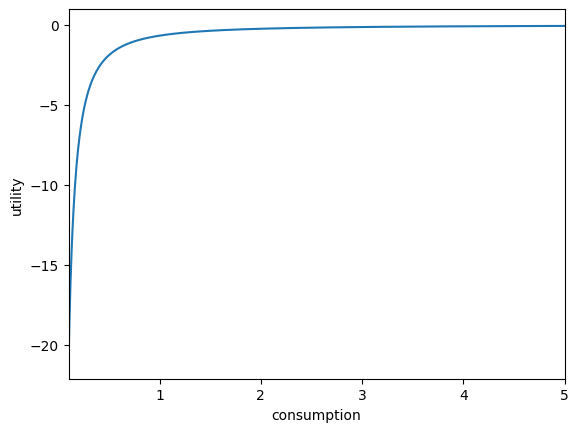

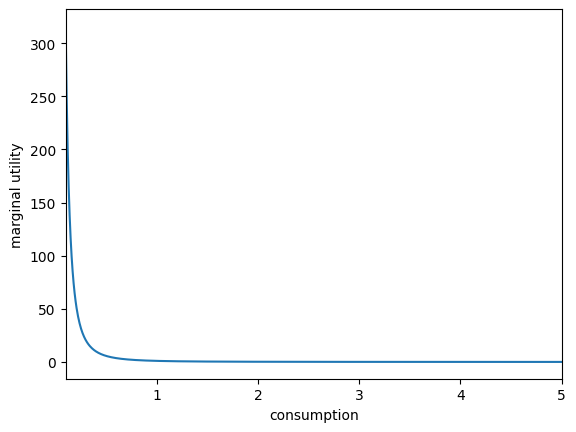

In [6]:
plt.xlabel("consumption")
plt.ylabel("utility")
plot_funcs(u, 0.1, 5.0)
plt.xlabel("consumption")
plt.ylabel("marginal utility")
plot_funcs(uP, 0.1, 5)

As a notational convention, HARK uses a capital `P` to denote "prime", and `_inv` for "inverse". `HARK.rewards` defines several layers of derivative and inverses for CRRA utility:

- `CRRAutility` : utility function
- `CRRAutilityP` : marginal utility function
- `CRRAutilityPP` : marginal marginal utility function
- `CRRAutilityPPP` : marginal marginal marginal utility function
- `CRRAutilityPPPP` : marginal marginal marginal marginal utility function
- `CRRAutility_inv` : inverse utility function
- `CRRAutilityP_inv` : inverse marginal utility function
- `CRRAutility_invP` : marginal inverse utility function
- `CRRAutilityP_invP` : marginal inverse marginal utility function

### Utility Function Structure

The second way to use CRRA utility is to simply import the class `UtilityFuncCRRA` and instantiate it with a single argument for $\rho$. This object then represents the utility function and *all* of its derivatives and inverses. Let's see an example.

In [7]:
U = UtilityFuncCRRA(2.0)  # CRRA utility function with rho=2

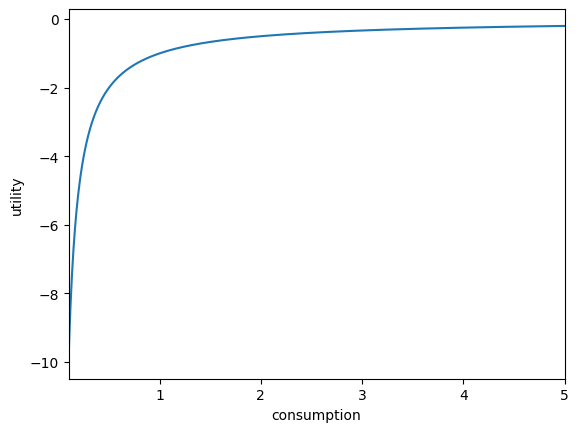

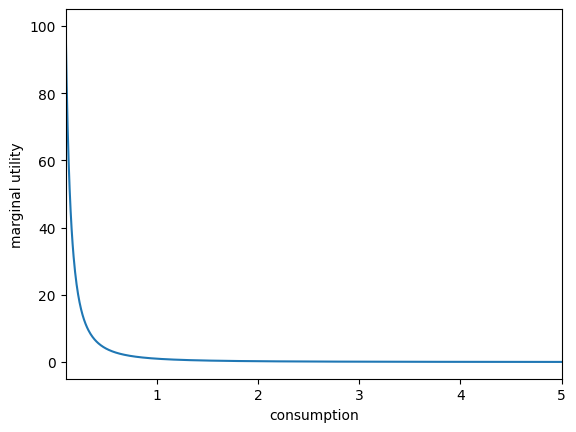

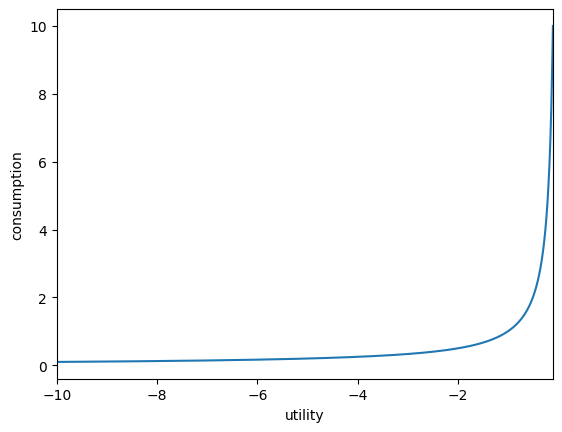

In [8]:
plt.xlabel("consumption")
plt.ylabel("utility")
plot_funcs(U, 0.1, 5.0)  # treat it like a function
plt.xlabel("consumption")
plt.ylabel("marginal utility")
plot_funcs(U.derivative, 0.1, 5)  # use its derivative method for marginal utility
plt.xlabel("utility")
plt.ylabel("consumption")
plot_funcs(U.inverse, -10.0, -0.1)  # use its inverse method

The `derivative` method accepts a second optional argument of `order` with a default of 1, indicating the order of the derivative (first to fourth order).

The `inverse` method also accepts an `order` argument as an ordered pair `(0,0)` to `(1,1)`. For a simple mnemonic, `order` refers to the number of `P`s in the function `CRRAutility[#1]_inv[#2]`. The default is `(0,0)`, which is just the inverse of utility.

### Other Utility Functions in `HARK.rewards`

Four other utility functions have various levels of support in HARK, but are rarely used:

- **Stone-Geary:** Modified CRRA utility of the form $U(c) = b \frac{(c+a)^{1-\rho}}{1-\rho}$, with a default of $b=1$.
- **Constant Absolute Risk Aversion (CARA):** Normalized exponential utility of the form $U(c) = 1 - \exp(-\alpha c) / \alpha$.
- **Cobb-Douglas:** Cobb-Douglas aggregator for an aribtrary number of goods: $U(x) = \prod_{j=1}^J x_j^{\zeta_j}$.
- **Constant Elastisticity of Substitution (CES)**: CES aggregator characterized by elasticity $\epsilon$, shares $\zeta$, scaling factor $\alpha$ and homogeneity degree $\eta$: $U(x) = \alpha \left(\prod_{j=1}^J \zeta_j x_j^\epsilon \right)^{\eta / \epsilon}$.

Each of these utility forms has a utility function class, but the inverse methods are not defined for multiple-input forms.

## Representing Distributions

The `HARK.distributions` module provides a fairly wide array of representations of distributions for random variables.

### Basics of Distributions in HARK

All distribution classes have some common methods and attributes:

- `seed` : An integer attribute that can be set at instantiation. It is used as the seed for the distribution's internal random number generator.
- `random_seed()` : A method to draw a *new* random seed for the distribution. This is not recommended for computations that need to be precisely replicated.
- `reset()` : A method to reset the distribution's internal RNG by using its own stored `seed`.
- `draw(N)` : A method to generate $N$ random draws from the distribution.
- `discretize(N, method)` : A method to generate a `DiscreteDistribution` based on this distribution object. The only universally required input is $N$, the number of nodes in the discretization, but a string `method` can be passed as well, along with method-specific `kwds`.
- `infimum` : The greatest lower bound for the support of the distribution; it is always an array, even for univariate distributions.
- `supremum` : The least upper bound for the support of the distribution; it is always an array.

### Our Workhorse: `DiscreteDistribution`

*Almost* all computation in HARK actually uses *discretized* approximations of continuous RVs. The default discretization method is `equiprobable` (which actually has options for *non*-equiprobable discretizations in some cases), rather than Gaussian methods. This approach is meant to ensure that the *mean* of the distribution is exactly preserved by the discretization.

The key attributes of a `DiscreteDistribution` are `pmv` and `atoms`. The `pmv` is the **probability mass vector**, a `np.array` that should sum to 1, representing the probability masses for each of the nodes.

The discretized nodes are stored in the `atoms` attribute as a 2D `np.array`, even for univariate distributions. The first dimension (`axis=0`) indexes multiple components of a multivariate distribution, and the second dimension (`axis=1`) index the nodes.

A `DiscreteDistribution` that is created from a continuous distribution object using its `discretize` method should have an attribute called `limit` with information about how it was generated:

- `dist` : a reference to the continuous distribution itself
- `method` : the name of the method that was used to build the approximation
- `N` : the number of nodes requested
- `infimum` : the infimum of the continuous distribution from which it was made
- `supremum` : the supremum of the continuous distribution from which it was made

We included this so that HARK's solvers can use (particularly) information about the "best" and "worst" things that can happen, even if they don't appear in the discretization. This is sometimes important for bounding behavior of the model solution.

### Say My Name: `DiscreteDistributionLabeled`

The default behavior in HARK is for multivariate distributions to simply be indexed by number. E.g. a joint distribution of permanent and transitory income shocks might have $\psi$ at index 0 and $\theta$ at index 1. However, we also have an extended class called `DiscreteDistributionLabeled` that allows more information to be provided.

The additional fields for a `Labeled` distribution are (all optional):

- `name` : a name or title for the distribution, for describing its purpose
- `attrs` : a dictionary of attributes, for arbitrary use
- `var_names` : a list of strings naming each variable in the distribution
- `var_attrs` : a list of dictionaries with attributes for each variable in the distribution

A `DiscreteDistributionLabeled` can be instantiated in two ways:

1) Passing a `pmv`, `atoms`, and `seed` along with any of the optional arguments, generating a completely new object.
2) Passing a `DiscreteDistribution` along with any optional arguments, effectively "converting" the input distribution.

### Example Usage

We won't show *everything* in `HARK.distribution` here, but this is a sampling (no pun intended) of some key features.

In [9]:
import numpy as np
from HARK.distributions import (
    Lognormal,
    add_discrete_outcome,
    add_discrete_outcome_constant_mean,
    DiscreteDistributionLabeled,
    expected,
)

In [10]:
# Make a lognormal distribution and draw twenty numbers from it
F = Lognormal(mu=0.2, sigma=0.7, seed=10202025)
print(F.draw(20))

[0.88164369 1.27060758 0.82340037 0.32759431 1.57918536 1.23739098
 1.52478804 2.82758116 1.77216365 0.45260362 1.03188809 0.77631269
 4.06323317 0.97823279 2.11448412 2.90854828 0.89516082 2.9296455
 0.8560163  0.75149165]


In [11]:
# Make a discrete approximation of the lognormal and print information about it
F_approx = F.discretize(N=9)
print(F_approx.pmv)  # equiprobable!
print(F_approx.atoms)  # univariate, but is a 2D array
print(np.dot(F_approx.atoms, F_approx.pmv))  # mean of discretization
print("Mean of true distribution is " + str(np.exp(F.mu + 0.5 * F.sigma**2)))

[0.11111111 0.11111111 0.11111111 0.11111111 0.11111111 0.11111111
 0.11111111 0.11111111 0.11111111]
[[0.38465583 0.61952063 0.80874565 1.0034799  1.2233456  1.49178328
  1.85298459 2.4281933  4.231703  ]]
[1.5604902]
Mean of true distribution is 1.5604901958326667


In [12]:
# Draw twenty numbers from the discretization
F_approx.draw(20)

array([2.4281933 , 0.38465583, 0.80874565, 0.61952063, 4.231703  ,
       0.61952063, 0.61952063, 2.4281933 , 1.49178328, 1.2233456 ,
       1.49178328, 1.0034799 , 2.4281933 , 1.85298459, 1.49178328,
       2.4281933 , 1.0034799 , 1.0034799 , 0.80874565, 0.61952063])

Notice that when drawing from the true distribution `F`, we got values from its entire support (any positive real), but when drawing from the 9 point equiprobable discretization, we can *only* get 9 different values.

In [13]:
# Add a point mass at zero
G = add_discrete_outcome(F_approx, x=0.0, p=0.1)
print(G.pmv)  # other probabilities proportionally scaled down
print(G.atoms)
print(np.dot(G.atoms, G.pmv))

[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
[[0.         0.38465583 0.61952063 0.80874565 1.0034799  1.2233456
  1.49178328 1.85298459 2.4281933  4.231703  ]]
[1.40444118]


In [14]:
# Add a point mass at zero, but preserve the original mean
H = add_discrete_outcome_constant_mean(F_approx, x=0.0, p=0.1)
print(H.pmv)
print(H.atoms)
print(np.dot(H.atoms, H.pmv))

[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
[[0.         0.42739536 0.68835626 0.89860627 1.11497766 1.35927289
  1.65753698 2.05887176 2.69799255 4.70189222]]
[1.5604902]


In [15]:
# Make a labeled version of that distribution
H_labeled = DiscreteDistributionLabeled.from_unlabeled(
    H, name="permanent income shocks", var_names=["PermShk"]
)

In [16]:
# Calculate the expectation of a function of our random variable
temp_func = lambda x, y: x["PermShk"] ** 2 + y
expected_value = expected(temp_func, H_labeled, args=(3.0,))
print(expected_value)

7.092812838769875


The `expected` utility is useful for writing shorter code within our solvers. It can be used with both ordinary `DiscreteDistribution`s and with `Labeled` ones. The function passed to `expected` as its first argument should always take a distribution as *its* first argument, and index by number or name. Additional arguments are provided *in order* as `args`.

## Estimation and Optimization

HARK doesn't provide many tools for estimating the parameters of particular models-- our take is that the details of each particular application are too bespoke to provide a meaningful interface for estimation. We do have a `HARK.estimation` module, but it is *mostly* a remapping of functions from `scipy.optimize`.

In particular, the functions `minimize_nelder_mead` and `minimize_powell` remap `scipy.optimize.fmin` and `scipy.optimize.fmin_powell`, with a few additional options. In particular, the former function permits an optional argument of `which_vars` as a Boolean array with length equal to the number of arguments of the function to be minimized; it indicates which dimensions should *actually* be optimized.

As usual for `scipy.optimize` functions, the minimand should accept a single *input vector*. That is, if there are 5 arguments to the function to be minimized, they should be passed as a single `np.array`.

HARK does provide one hand-programmed optimizer: a parallelized Nelder-Mead minimizer, adapted from Lee and Wiswall. This uses "embarrassingly parallel" techniques from `joblib`, literally writing to and reading from disk as it spawns and deletes new Python processes. Because of this significant overhead, it should *only* be used for functions that are relatively "expensive" to evaluate-- a few seconds, at least.

See the full documentation for `parallelNelderMead` for all of the options, but the key inputs are:

- `obj_func` : The function to be optimized, with the same format as usual.
- `guess` : Starting point for the optimization, around which a simplex will be built.
- `perturb` : A vector of perturbations in each argument, used for building the simplex. If `perturb[j]` is `0`, that dimension is excluded from the optimization. If no `perturb` is provided, the default is to optimize all dimensions with an initial simplex of 10% of the `guess`.
- `P` : The degree of parallelization-- how many nodes of the simplex to attempt to update on each iteration. Defaults to 1, which is standard Nelder-Mead.
- `maxthreads` : The largest number of Python threads to run simultaneously. This can be no greater or less than `P`, which is relevant when evaluating the initial simplex or executing a shrink step.
- `name` : A filename for optionally storing progress of the search; must be used in conjuction with next two arguments. Useful for very long optimizations that might be interupted by computer downtime.
- `resume` : Whether the optimization should resume from prior saved progress (in file `name`) or start from scratch.
- `savefreq` : Frequency (in number of iterations) of writing progress to disk, defaulting to 1 (write after every iteration).

## Parallelizing Operations

HARK has a basic tool for parallelizing operations across `AgentType` instances. If you have a population of agents that has *ex ante* heterogeneity-- they differ in their parameters, or possibly even in their model, their microeconomic problems can be solved independently and simultaneously. If there is no macroeconomic interaction *among* `AgentType` instances, then their models can be *simulated* independently as well.

The relevant function is `HARK.parallel.multi_thread_commands`, which takes three arguments:

- `agent_list` : a list of `AgentType` instances for which parallel work should be performed
- `command_list` : a list of strings naming methods to be run
- `num_jobs` : optionally, a maximum number of Python threads to spawn

The function returns no output; `agent_list` itself is changed by running `multi_thread_commands`.

There are two caveats when using `multi_thread_commands`:

1) Each element of `command_list` must include `()` at the end, e.g. `solve()`. This will be changed in the future.
2) `AgentType` instances can be large and thus take considerable time to `pickle` when writing to disk (and then reading from disk). This is particularly the case when model is solved and simulated by the multithreaded process, as both `solution` and `history` can be large. If you find that this is a problem, try to find ways to "pre-process" the output at the `AgentType` instance level, before it exits the spawned thread, and delete the attributes that you don't strictly "need".

We have also included a trivial `multi_thread_commands_fake` function, which replicates the interface of `multi_thread_commands` but does *not* use the `Parallel` package for spawning processes. Instead, it simply loops over the elements of `agent_list` and executes the methods for each one. This function is included to have a quick way to "turn off" multi-threading in your code.

## Life-Cycle Parameter Calibrations

The default parameters for each `AgentType` subclass are just meant to be workable examples, not represent anything "realistic". Some of the default parameters are reasonable or vaguely in the ballpark of values you might get from empirical measurements (e.g. a `CRRA` of 2 or risk free interest factor of 1.02), but this is mostly coincidence or us being too lazy to make up unreasonable values.

The `HARK.Calibration` module includes some off-the-shelf calibrations of life-cycle processes, estimated by people who are better with data than we are. It also has some functions for making particular parametric distributions for income processes.

### Income Processes

In [17]:
from HARK.Calibration.Income.IncomeTools import Cagetti_income, parse_income_spec

See the documentation for full details, but the main tool for handling life-cycle income specifications is `parse_income_spec`. This function takes a large number of inputs, but *conveniently* we have provided some dictionaries for quick use. This function produces a dictionary with a variety of income process parameters, which can be passed to an `AgentType` subclass to produce a realistically calibrated instance of that class (with HARK's default income process, or something similar to it).

In [18]:
# Make an income process dictionary for high-school-educated men based on Cagetti (2003)
my_income_params = parse_income_spec(age_min=22, age_max=110, **Cagetti_income["HS"])
print(my_income_params.keys())
print(
    len(my_income_params["PermShkStd"])
)  # number of non-terminal periods in the model

dict_keys(['PermGroFacAgg', 'PermGroFac', 'PermShkStd', 'TranShkStd', 'P0', 'pLogInitMean', 'T_retire'])
88


### Mortality Processes

HARK can also construct life-cycle mortality probabilities based on Social Security Administration actuarial tables. This tool is currently buried quite deep in HARK, at `HARK.Calibration.life_tables.us_ssa.SSATools.parse_ssa_life_table`, but we will expose it more conveniently in the near future.

In [19]:
from HARK.Calibration.life_tables.us_ssa.SSATools import parse_ssa_life_table

In [20]:
# Make survival probabilities for men born in 1980
my_LivPrb = parse_ssa_life_table(age_min=22, age_max=110, female=False, cohort=1980)
print(len(my_LivPrb))
print(my_LivPrb[:10])  # first 10 survival probabilities, from start of model life

88
[np.float64(0.998541), np.float64(0.998511), np.float64(0.998545), np.float64(0.99852), np.float64(0.998489), np.float64(0.998549), np.float64(0.998583), np.float64(0.998606), np.float64(0.998592), np.float64(0.998535)]


Unlike `parse_income_spec`, this function returns *only* survival probabilities, which are used as `LivPrb` in most HARK models.

### Using Parsed Parameters in a Model

Let's show a simple example of how to use the parameters we imported in an `AgentType` instance.

In [21]:
# Put the parsed parameters together into an IndShockConsumerType
T = 110 - 22  # number of non-terminal periods
CalibratedType = IndShockConsumerType(
    LivPrb=my_LivPrb,
    T_cycle=T,
    Rfree=T * [1.02],
    **my_income_params,
)

In [22]:
# Solve the life-cycle problem for this agent
CalibratedType.solve()

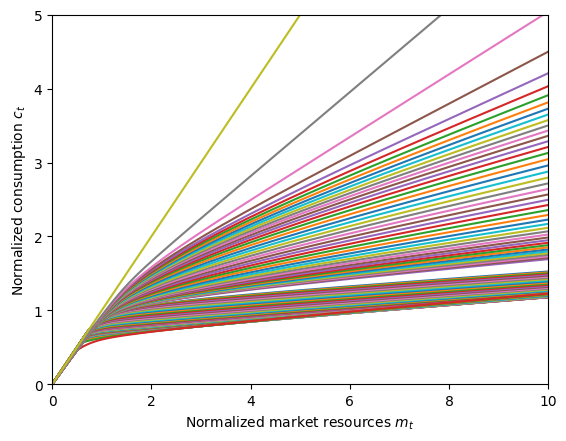

In [23]:
# Plot the consumption function at all ages
CalibratedType.unpack("cFunc")
plt.xlabel(r"Normalized market resources $m_t$")
plt.ylabel(r"Normalized consumption $c_t$")
plt.ylim(0.0, 5.0)
plot_funcs(CalibratedType.cFunc, 0.0, 10.0)

## Quick and Dirty Function Plots

HARK has some basic convenience functions for making simple function plots. These are mostly meant to be used in live/interactive sessions when you're exploring your model, *not* to produce perfectly formatted figures for publication. We have provided very limited formatting options, and no option to save anyway.

### Basic 1D Plotting: `plot_funcs`

Throughout this notebook and others, you've probably noticed us using `plot_funcs`, which is used for plotting one or more real functions with simple syntax: `plot_funcs(your_function(s), bottom, top)`. Note that `your_function(s)` can be a single function or a list of functions.

You can pre-format the figure with `matplotlib` instructions *before* calling `plot_funcs`. In this notebook, we sometimes set the `ylim`, `xlabel`, and `ylabel`. The arguments `xlabel`, `ylabel`, and `legend_kwds` can also optionally be passed to `plot_funcs`.

### Plotting "Slices" of Functions with Multiple Arguments

Many functions produced by HARK have more than one argument, such as when there is more than one continuous state variable. HARK includes a simple function for quickly plotting cross-sections or "slices" of such functions with `plot_func_slices`.

The key concepts for `plot_func_slices` are the `xdim` and `zdim`, representing the $x$ plotting dimension (the function argument that is continuously varied along the horizontal axis) and the discretized $z$ dimension (the function argument that takes on a different value for each slice). Both of these are index numbers referencing the argument number for the function to be plotted; by default, `xdim=0` and `zdim=1`.

The syntax for `plot_func_slices` is somewhat more complex than for `plot_funcs`. In addition to passing the function itself and the lower and upper bounds on $x$, you must also specify which values of $z$ should be plotted. This can be done in two ways:

1. Pass arguments called `zmin` and `zmax` to specify the lower and upper bounds of $z$. By default, a grid with 11 linearly spaced points will be used, but this can be changed with the arguments `zn` and `zorder`.
2. Pass an argument called `Z` as a list (or array) of user-specified $z$ values.

You must choose exactly one of these methods; passing neither or both will result in an error.

Let's use the consumption function for `PrefShockConsumerType` as an example, first importing what we need.

In [24]:
from HARK.models import PrefShockConsumerType
from HARK.utilities import plot_func_slices

PrefType = PrefShockConsumerType(cycles=0)
PrefType.solve()
PrefType.unpack("cFunc")  # make solution[t].cFunc available as cFunc[t] for convenience

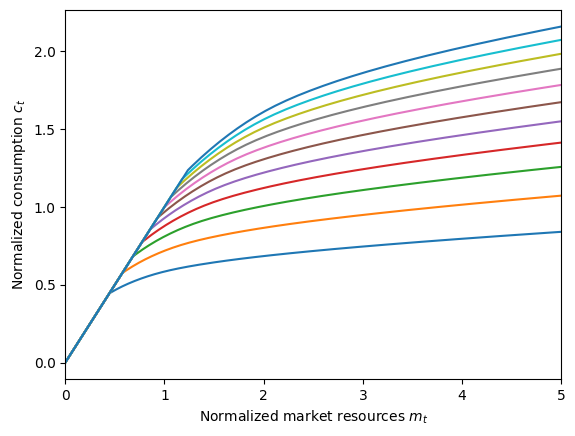

In [25]:
plot_func_slices(
    PrefType.cFunc[0],
    0.0,
    5.0,
    zmin=0.35,
    zmax=2.7,
    xlabel=r"Normalized market resources $m_t$",
    ylabel=r"Normalized consumption $c_t$",
)

Each one of those plots represents the consumption function when holding fixed preference shock $\eta$ at some level of interest (for values between 0.35 and 2.7). We could instead plot consumption with respect to $\eta$ while holding $m_t$ fixed by specifying `xdim` and `zdim`.

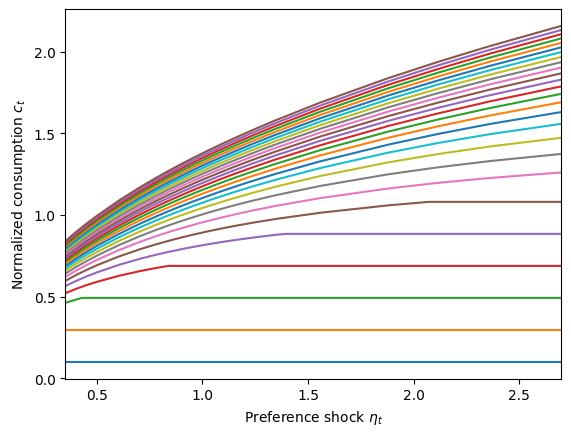

In [26]:
plot_func_slices(
    PrefType.cFunc[0],
    0.35,
    2.7,
    xdim=1,
    zdim=0,
    zmin=0.1,
    zmax=5.0,
    zn=26,
    xlabel=r"Preference shock $\eta_t$",
    ylabel=r"Normalized consumption $c_t$",
)

Notice here that for low market resource levels (the blue, orange, and green plots near the bottom), the consumption function is *flat* with respect to $\eta$. That represents the *liquidity constrained* portion of the consumption function where the agent is already spending as much as they can. Increasing their preference for consumption makes them *want* to consume more, but they don't *actually* consume more. At somewhat higher values of $m_t$, they have high enough market resources that they are unconstrained for low $\eta$ but become constrained for higher $\eta$. At sufficiently high $m_t$, the consumer is not liquidity constrained for any $\eta$ plotted here.

## Finding "Target" or Steady-State Values

Most HARK `AgentType` subclasses now have a method to automatically calculate the "target" level of an endogenous state variable, using the `find_target` method. The target level of a state $x$ satisfies $\mathbb{E}[ \Delta x ] = 0$, so that an agent currently at $x_t$ expects to be at the same value (on average) in $t+1$ if they survive. Moreover, a target level must be *locally stable*, so that at values of $x_t$ below the target, the agent expects $\mathbb{E}[ \Delta x ] > 0$ and for $x_t$ above the target, they expect the state to fall.

### Basic Usage for `find_target`

The basic syntax is straightforward in many cases: the user simply names the variable they want to find the target for, e.g. `MyType.find_target("mNrm")`. (Recall from the [simulation introduction](Simulation-Intro.ipynb) that you can view a list of model variable names with `MyType.describe_model()`.) Let's first do a quick example with the workhorse `IndShockConsumerType`:

In [27]:
MyType = IndShockConsumerType(cycles=0)  # default parameters, infinite horizon
MyType.solve()  # need to solve the model in order to find target or steady state
m_targ = MyType.find_target("mNrm")
print("Found target market resources ratio of {:.6f}".format(m_targ))

Found target market resources ratio of 1.492786


Because it's the canonical workhorse model in HARK, `IndShockConsumerType` already had a "handwritten" method for finding target market resources, long before we added the generic method. As a quick test, let's compare that "hand calculated" value to the one from the general method:

In [28]:
m_targ_old = MyType.bilt["mNrmTrg"]
print(
    "The hand-coded method found a target market resources ratio of {:.6f}".format(
        m_targ_old
    )
)

The hand-coded method found a target market resources ratio of 1.492786


Note that the `find_target` method has some limitations:

1) It only works on standard infinite horizon models: `cycles=0` and `T_cycle=1`.
2) It can currently only solve for one endogenous state variable at a time; this excludes `BasicHealthConsumerType`.

### Providing Additional Required Information

HARK has several models with one or more *exogenous* state variables, e.g. the persistent income level `pLvl` for `PersistentShockConsumerType` or the preference shock `PrefShk` for the `PrefShockConsumerType`. For those types, `pLvl` and `PrefShk` must respectively be known at the time the consumption decision is made. For `find_target` to work, the user needs to *also* pass the steady-state value of the exogenous state variable(s) as keyword arguments. In all current HARK models, the steady state of such variables should be obvious to the user based on the parameters.

For example, the default parameters for `PersistentShockConsumerType` have agents being "born" with an average `pLvl` of $1$, and then they experience mean one persistent income shocks with no growth trend. It should be pretty obvious that the "steady state" value of `pLvl` is $1$.

In [29]:
from HARK.models import PersistentShockConsumerType

PersistentType = PersistentShockConsumerType(cycles=0)
PersistentType.solve()
m_targ_prst = PersistentType.find_target("mLvl", pLvl=1.0)
print(
    "The default persistent shock consumer type has target market resources level of {:.6f}".format(
        m_targ_prst
    )
)

The default persistent shock consumer type has target market resources level of 1.730613


As a second example, the default parameters for a `PrefShockConsumerType` involve a mean one preference shock distribution, so target market resources can be found with:

In [30]:
from HARK.models import PrefShockConsumerType

PrefShockType = PrefShockConsumerType(cycles=0)
PrefShockType.solve()
m_targ_pref = PrefShockType.find_target("mNrm", PrefShk=1.0)
print(
    "The default preference shock consumer type has target market resources level of {:.6f}".format(
        m_targ_pref
    )
)

The default preference shock consumer type has target market resources level of 1.525104


### Common Failure Modes for `find_target`

The target level of a state variable does not always exist. When `find_target` fails to find *any* target level, it returns `np.nan`. Note that this can occur for several reasons:

1) There really is no target value anywhere.
3) There is a target value, but it is outside of the search bounds; by default, $x \in [0,100]$ but can be changed with argument `bounds`.
4) There is a target value, but additional state information needed to be passed to `find_target`.

Let's see an example for each of these failure modes. First, the agent might be so patient that (even though their policy function is well defined), they always want to accumulate more wealth, and there is simply no target anywhere.

In [31]:
PatientType = IndShockConsumerType(cycles=0, DiscFac=1.0)
PatientType.solve()
print(PatientType.bilt["mNrmTrg"])
print(PatientType.find_target("mNrm"))

nan
nan


Second, the target value exists, but is outside the default bounds. To make this happen, we'll construct a consumer who has no artificial borrowing constraint *and* never faces a low-income "unemployment" shock. The lower bound of their `mNrm` state space goes to a significantly negative level, and the target $m_t$ is below zero, outside of the default search region.

In [32]:
UnboundType = IndShockConsumerType(cycles=0, UnempPrb=0.0, BoroCnstArt=None)
UnboundType.solve()
print(UnboundType.bilt["mNrmTrg"])
print(UnboundType.find_target("mNrm"))

-1.7250338547911441
nan


To fix this, let's get the lower boundary of `mNrm` and use that as the lower bound of the search.

In [33]:
mNrmMin = UnboundType.solution[0].mNrmMin
print(UnboundType.find_target("mNrm", bounds=[mNrmMin, 100.0]))

-1.7250338508597622


The third failure mode is an error by the user in providing sufficient information. Suppose you wanted to know steady state `bNrm`, bank balances before receiving labor income `yNrm`. Because transitory income shocks are mean one in the default parameters, and `yNrm=TranShk`, we should expect that target `bNrm` is *exactly* one less than target `mNrm`. But if we just ask `find_target` for target `bNrm`, it will fail:

In [34]:
print(MyType.find_target("bNrm"))

nan


What happened here? To understand, we need to look at how the agent's model is written out:

In [35]:
MyType.describe_model()

ConsIndShock: Consumption-saving model with permanent and transitory income shocks and a risk-free asset.

----------------------------------
%%%%%%%%%%%%% SYMBOLS %%%%%%%%%%%%
----------------------------------
kNrm (float)        : beginning of period capital, normalized by p_{t-1}
pLvlPrev (float)    : inbound permanent income level, before growth
yNrm (float)        : normalized labor income
pLvl (float)        : permanent income level
bNrm (float)        : normalized bank balances
mNrm (float)        : normalized market resources
cNrm (float)        : normalized consumption
aNrm (float)        : normalized end-of-period assets
live (bool)         : whether the agent survives
Rfree (param)       : risk free return factor on assets
PermGroFac (param)  : expected permanent income growth factor
LivPrb (param)      : survival probability at end of period
cFunc (func)        : consumption function over market resources
IncShkDstn (dstn)   : joint distribution of permanent and transitory

When `find_target` is asked to find target $b_t$, it looks through the dynamics and finds where `bNrm` is set, then tests different values of it by *starting* the period at that point and looping back around to the same spot. When it does so, it uses fake / dummy values for *all* model variables that should have been assigned before `bNrm`. That *includes* income `yNrm`, so in the *very next step*, it calculates `mNrm = bNrm + yNrm`... and uses nonsense data for `yNrm`. It thus fails to find a target $b_t$ because it doesn't have correct information about $y_t$.

To fix this, we need to pass `yNrm=1.0`, the average or steady state value, to the method as well:

In [36]:
print(MyType.find_target("bNrm", yNrm=1.0))

0.49278579223515967


As expected, target $b_t$ is exactly $1$ less than target $m_t$ for this agent.

### Guiding Principle for Additional Required Information

In general, you should only try to calculate a target value at "informational chokepoints": moments in the sequence of events where you *know* what variables will ever be referenced beyond that point. The most straightforward "informational chokepoint" is *usually* the decision-time state space: whatever the control variable (and Bellman value function) is conditioned on.

To make this point clear, consider the preference shock model. To get a sensible target for $m_t$, we needed to pass the mean or steady state value of preference shock $\eta_t$, which was known to be $1$. However, we do *not* need to pass `PrefShk = 1.0` if we ask for target end-of-period assets $a_t$. At the *end* of the period, $\eta_t$ has already played its role and is water under the bridge; it is not informative about the future.

In [37]:
print(PrefShockType.find_target("aNrm"))

0.623920206603688
